In [1]:
import numpy as np
from scipy.special import owens_t
import matplotlib.pyplot as plt
# get a logger
import logging
logger = logging.getLogger(__name__)

# Data Model Creation

In [2]:
# Let's sample two random vectors in 2d from a normal distribution such that their norm is 1
helper = np.random.uniform(0, 2*np.pi)
theta = np.array([np.cos(helper), np.sin(helper)])
helper = np.random.uniform(helper-np.pi/2, helper+np.pi/2)
w = np.array([np.cos(helper), np.sin(helper)])
print("theta: ", theta)
print("w: ", w)

# # fix w to be exactly orthogonal to theta
# w = np.array([-theta[1], theta[0]])

# fix w to be at a 45 degree angle to theta
theta = np.array([-1, 1])
theta = theta / np.linalg.norm(theta)
w = np.array([0, 1])
w = w / np.linalg.norm(w)


theta:  [-0.63243815  0.77461086]
w:  [-0.97170434 -0.23620049]


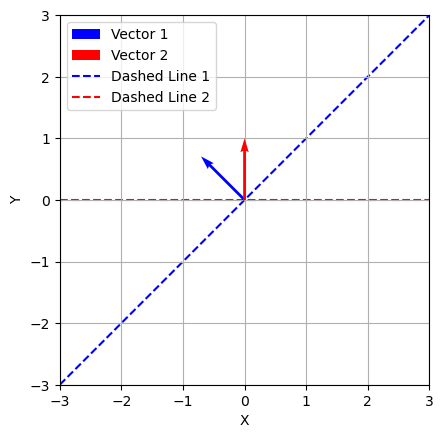

In [3]:

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the vectors as solid lines with arrows
ax.quiver(0, 0, theta[0], theta[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Vector 1', linewidth=1.5, zorder=2)
ax.quiver(0, 0, w[0], w[1], angles='xy', scale_units='xy', scale=1, color='red', label='Vector 2', linewidth=1.5, zorder=2)

lim = 3

# Plot the dashed lines for each vector
ax.plot([-lim, lim], [theta[0]*lim/theta[1],-theta[0]*lim/theta[1]], 'b--', label='Dashed Line 1', zorder=1)
ax.plot([-lim, lim], [w[0]*lim/w[1],-w[0]*lim/w[1]], 'r--', label='Dashed Line 2', zorder=1)

# Set axis limits
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

# make the grid spacing rectangular
ax.set_aspect('equal', adjustable='box')

# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

# Show the plot
plt.grid()
plt.show()


# Create Ground Truth

In [4]:
from data_model import VanillaGaussianDataModel
data_model = VanillaGaussianDataModel(2,logger,source_pickle_path="")
data_set = data_model.generate_data(10000,0)
X = data_set.X

In [5]:
# We have our own teacher and must create the labels ourselves
y_teacher = np.sign(X.dot(theta))
y_student = np.sign(X.dot(w))

# Create four sets of data given the labels
true_positive = X[(y_student == 1) & (y_teacher == 1)]
true_negative = X[(y_teacher == -1) & (y_student == -1)]
false_positive = X[(y_student == 1) & (y_teacher == -1)]
false_negative = X[(y_student == -1) & (y_teacher == 1)]

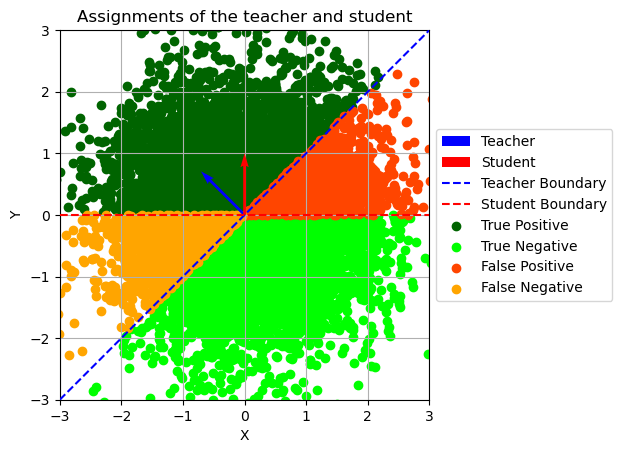

In [6]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the vectors as solid lines with arrows
ax.quiver(0, 0, theta[0], theta[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Teacher', linewidth=1.5, zorder=2)
ax.quiver(0, 0, w[0], w[1], angles='xy', scale_units='xy', scale=1, color='red', label='Student', linewidth=1.5, zorder=2)

lim = 3

# Plot the dashed lines for each vector
ax.plot([-lim, lim], [theta[0]*lim/theta[1],-theta[0]*lim/theta[1]], 'b--', label='Teacher Boundary', zorder=3)
ax.plot([-lim, lim], [w[0]*lim/w[1],-w[0]*lim/w[1]], 'r--', label='Student Boundary', zorder=3)

# Plot the data
ax.scatter(true_positive[:,0], true_positive[:,1], color='darkgreen', label='True Positive', zorder=1)
ax.scatter(true_negative[:,0], true_negative[:,1], color='lime', label='True Negative', zorder=1)
ax.scatter(false_positive[:,0], false_positive[:,1], color='orangered', label='False Positive', zorder=1)
ax.scatter(false_negative[:,0], false_negative[:,1], color='orange', label='False Negative', zorder=1)


# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
# put the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set axis limits
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

# make the grid spacing rectangular
ax.set_aspect('equal', adjustable='box')

plt.title("Assignments of the teacher and student")

# Show the plot
plt.grid()

# Save the fig in "Assets/intuition/naive_adv_test_error.pdf"
# plt.savefig("Assets/intuition/naive_adv_test_error_original_data.pdf", bbox_inches='tight')
plt.show()


In [7]:
# Let's compute the angle
m = w.dot(theta)
q = np.linalg.norm(w)
angle = np.arccos(m/np.sqrt(q))/np.pi
print("Angle: ", angle)

# Let's compute the ratio of true positives to the entire set
ratio = 1-(len(true_positive) + len(true_negative))/(len(X))
print("False to True Ratio: ", ratio)

Angle:  0.25000000000000006
False to True Ratio:  0.24770000000000003


# Attack and evaluate against the ground truth teacher labels

In [8]:
# Now let's attack our datset with an epsilon attack
epsilon = 2

# We attack the dataset by subtracting y_student*epsilon*w/||w|| from X
X_attacked = X - epsilon*y_teacher[:,np.newaxis]*w/np.linalg.norm(w)


print("Mean of the original data: ", np.mean(X))
print("Mean of the attacked data: ", np.mean(X_attacked))

# Let's compute the attacked labels for teacher and student
y_student_attacked = np.sign(X_attacked.dot(w))
y_teacher_attacked = np.sign(X_attacked.dot(theta))

# Create four sets of data given the labels
true_positive_attacked = X_attacked[(y_student_attacked == 1) & (y_teacher == 1)]
true_negative_attacked = X_attacked[(y_teacher == -1) & (y_student_attacked == -1)]
false_positive_attacked = X_attacked[(y_student_attacked == 1) & (y_teacher == -1)]
false_negative_attacked = X_attacked[(y_student_attacked == -1) & (y_teacher == 1)]



Mean of the original data:  0.008402389927451993
Mean of the attacked data:  -0.0055976100725480035


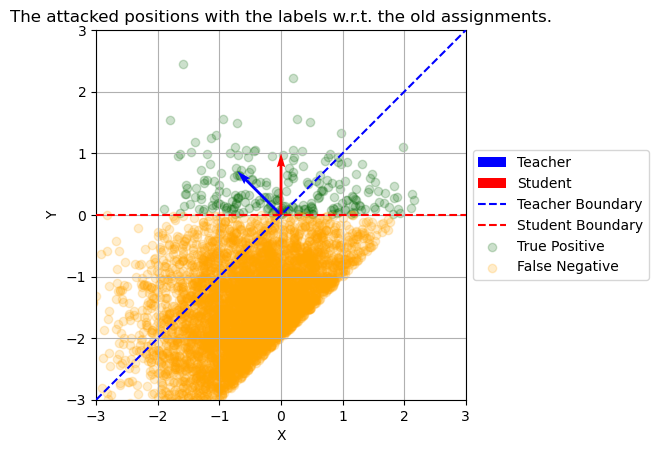

In [9]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the vectors as solid lines with arrows
ax.quiver(0, 0, theta[0], theta[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Teacher', linewidth=1.5, zorder=2)
ax.quiver(0, 0, w[0], w[1], angles='xy', scale_units='xy', scale=1, color='red', label='Student', linewidth=1.5, zorder=2)

lim = 3

# Plot the dashed lines for each vector
ax.plot([-lim, lim], [theta[0]*lim/theta[1],-theta[0]*lim/theta[1]], 'b--', label='Teacher Boundary', zorder=3)
ax.plot([-lim, lim], [w[0]*lim/w[1],-w[0]*lim/w[1]], 'r--', label='Student Boundary', zorder=3)

# Plot the data
ax.scatter(true_positive_attacked[:,0], true_positive_attacked[:,1], color='darkgreen', label='True Positive', zorder=1,alpha=0.2)
# ax.scatter(true_negative_attacked[:,0], true_negative_attacked[:,1], color='lime', label='True Negative', zorder=1,alpha=0.2)
# ax.scatter(false_positive_attacked[:,0], false_positive_attacked[:,1], color='orangered', label='False Positive', zorder=1,alpha=0.2)
ax.scatter(false_negative_attacked[:,0], false_negative_attacked[:,1], color='orange', label='False Negative', zorder=1,alpha=0.2)


# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
# put the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set axis limits
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

# make the grid spacing rectangular
ax.set_aspect('equal', adjustable='box')

plt.title("The attacked positions with the labels w.r.t. the old assignments.")

# Show the plot
plt.grid()
plt.show()


In [10]:
# Let's compute the angle
m = w.dot(theta)
q = np.linalg.norm(w)
rho = theta.dot(theta)
# print("m: ", m)
# print("q: ", q)
# print("rho: ", rho)
angle = np.arccos(m/np.sqrt(q))/np.pi
print("Angle: ", angle)

# Let's compute the error using the new formula
from scipy.special import erf, owens_t
b = epsilon 
owens_part = - 2 * owens_t( b, m/np.sqrt(rho*q-m**2))
gen_error = 0.5 + 0.5*erf(b/np.sqrt(2)) + owens_part
print("Generalization Error: ", gen_error)
print("erf part", 0.5 + 0.5*erf(b/np.sqrt(2)) )
print("owens part", owens_part)


# Let's compute the ratio of true positives to the entire set
ratio = 1-(len(true_positive_attacked) + len(true_negative_attacked))/(len(X))
print("False to True Ratio: ", ratio)

# # Compute the ratio of true positives to false negatives
# ratio = (len(true_positive_attacked))/(len(false_negative_attacked))
# print("True Positive to False Negative Ratio: ", 1-ratio)

# # compute the ratio of true negatives to false positives
# ratio = (len(true_negative_attacked))/(len(false_positive_attacked))
# print("True Negative to False Positive Ratio: ", 1-ratio)


Angle:  0.25000000000000006
Generalization Error:  0.9550173046073012
erf part 0.9772498680518208
owens part -0.02223256344451965
False to True Ratio:  0.9538


In [11]:
# Let's try directly attacking the activation
X_attacked = X - epsilon*y_teacher[:,np.newaxis]*w/np.linalg.norm(w)
y_attacked = np.sign(X_attacked.dot(w))

# Let's count the number of true positives
true_positive_attacked_old_position = X[(y_attacked == 1) & (y_teacher == 1)]
true_negative_attacked_old_position = X[(y_attacked == -1) & (y_teacher == -1)]
false_positive_attacked_old_position = X[(y_attacked == 1) & (y_teacher == -1)]
false_negative_attacked_old_position = X[(y_attacked == -1) & (y_teacher == 1)]

# Let's count the number of true positives
true_positive_attacked_new_position = X_attacked[(y_attacked == 1) & (y_teacher == 1)]
true_negative_attacked_new_position = X_attacked[(y_attacked == -1) & (y_teacher == -1)]
false_positive_attacked_new_position = X_attacked[(y_attacked == 1) & (y_teacher == -1)]
false_negative_attacked_new_position = X_attacked[(y_attacked == -1) & (y_teacher == 1)]


# arrow directions using the correct length from old position to new position
true_positive_attacked_old_position_direction = true_positive_attacked_new_position - true_positive_attacked_old_position
true_negative_attacked_old_position_direction = true_negative_attacked_new_position - true_negative_attacked_old_position
false_positive_attacked_old_position_direction = false_positive_attacked_new_position - false_positive_attacked_old_position
false_negative_attacked_old_position_direction = false_negative_attacked_new_position - false_negative_attacked_old_position

# combine the true positives and the false negatives
combined = np.concatenate((true_positive_attacked, false_negative_attacked), axis=0)
# print the mean of the combined set
print("Mean of the combined set: ", np.mean(combined, axis=0))

# combine the true positives and the false negatives on the old position
combined_old_position = np.concatenate((true_positive_attacked_old_position, false_negative_attacked_old_position), axis=0)
# print the mean of the combined set
print("Mean of the combined set on the old position: ", np.mean(combined_old_position, axis=0))

Mean of the combined set:  [-0.55682552 -1.42177341]
Mean of the combined set on the old position:  [-0.55682552  0.57822659]


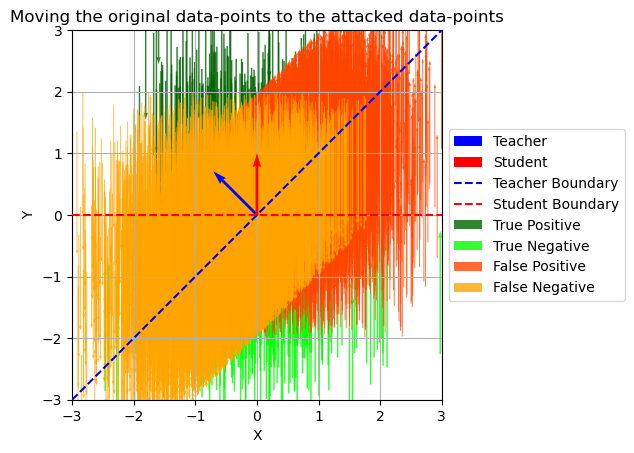

In [12]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the vectors as solid lines with arrows
ax.quiver(0, 0, theta[0], theta[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Teacher', linewidth=1.5, zorder=2)
ax.quiver(0, 0, w[0], w[1], angles='xy', scale_units='xy', scale=1, color='red', label='Student', linewidth=1.5, zorder=2)

lim = 3

# Plot the dashed lines for each vector
ax.plot([-lim, lim], [theta[0]*lim/theta[1],-theta[0]*lim/theta[1]], 'b--', label='Teacher Boundary', zorder=3)
ax.plot([-lim, lim], [w[0]*lim/w[1],-w[0]*lim/w[1]], 'r--', label='Student Boundary', zorder=3)

# Plot the data
ax.quiver(true_positive_attacked_old_position[:,0], true_positive_attacked_old_position[:,1],true_positive_attacked_old_position_direction[:,0],true_positive_attacked_old_position_direction[:,1],scale=1,scale_units="xy", angles="xy", color='darkgreen', label='True Positive', zorder=1,alpha=0.8)
ax.quiver(true_negative_attacked_old_position[:,0], true_negative_attacked_old_position[:,1],true_negative_attacked_old_position_direction[:,0],true_negative_attacked_old_position_direction[:,1],scale=1,scale_units="xy", angles="xy", color='lime', label='True Negative', zorder=1,alpha=0.8)
ax.quiver(false_positive_attacked_old_position[:,0], false_positive_attacked_old_position[:,1],false_positive_attacked_old_position_direction[:,0],false_positive_attacked_old_position_direction[:,1],scale=1,scale_units="xy", angles="xy", color='orangered', label='False Positive', zorder=1,alpha=0.8)
ax.quiver(false_negative_attacked_old_position[:,0], false_negative_attacked_old_position[:,1],false_negative_attacked_old_position_direction[:,0],false_negative_attacked_old_position_direction[:,1],scale=1,scale_units="xy", angles="xy", color='orange', label='False Negative', zorder=1,alpha=0.8)



# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
# put the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set axis limits
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

# make the grid spacing rectangular
ax.set_aspect('equal', adjustable='box')

plt.title("Moving the original data-points to the attacked data-points")

# Show the plot
plt.grid()
# plt.savefig("Assets/intuition/naive_adv_test_error_attacked.pdf", bbox_inches='tight')



plt.show()




If we move a point, for which the student thinks it's falsely negative, away from the decision boundary towards the negative samples, the student still believes that the point remains falsely negative. 

Depending on the teacher boundary however, it's possible that a point that is falsely negative - Meaning the student assigns the label negative, the teacher assigns the label positive - is moved accross the teacher boundary as well. Saying that after the attack, even the teacher would call the point truely negative, when in fact it was positive all along.

We would like to measure, how many points the teacher would get wrong after the attack. As of now, we have measured how many points the student will get wrong. Due to the angle between teacher and student, after the attack the student will classify some points remmaining true positives, even though the teacher would now misclassify them, and call them negatives. And there will be points the student will wrongly classify as negative, even though the teacher would still classify them correctly.

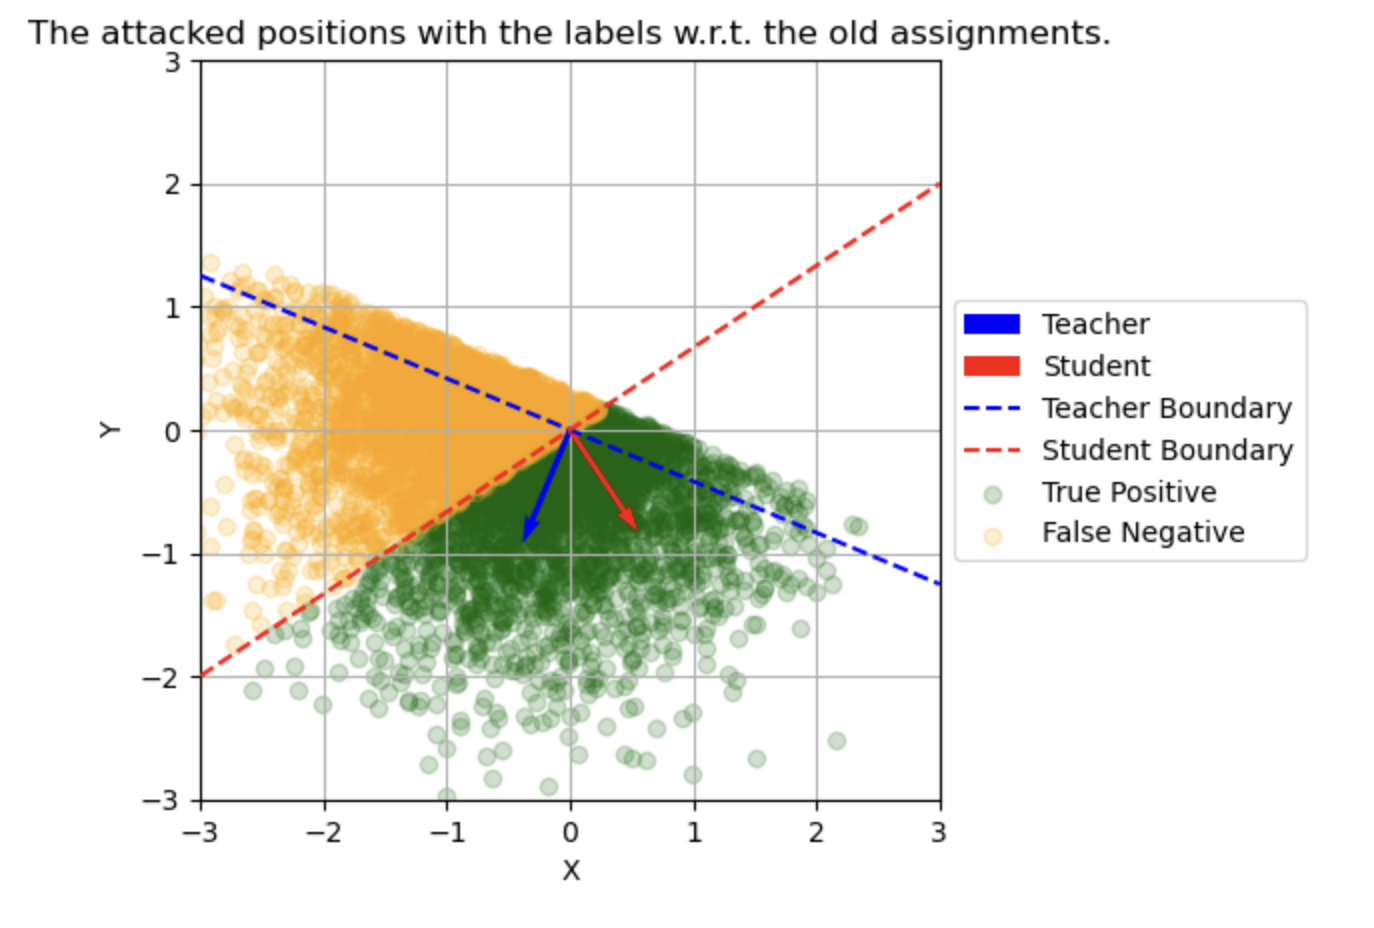

So essentially we would like to measure the teacher's error rate separately. These are the areas within the boundaries. On the picture on the left and right of the crossing point

Also, we would like to understand our formula for the student's error rate.

Remember, that we computed

$E_S = \Phi(\varepsilon) - 2 T(\varepsilon, \frac{m}{\sqrt{\rho q - m^2}}) $


The Owen-T function has the following interpretation:

Suppose you have two independent standard gaussians $X$ and $Y$.

The T-function gives you the probability, that $X \geq \varepsilon$ and $0 \leq Y \leq \frac{m}{\sqrt{\rho q - m^2}} X $

$\Phi$ is just the cumulative distribution function of a standard gaussian.

$m$ is the dot product between teacher and student, and $\sqrt{\rho q - m^2}$ is the area spanned by the teacher and student vectors

So in what space do $Y$ and $X$ live and what do they represent?


One way to think about this is to consider the role of $\varepsilon$ in our model.
Remember that classes are assigned as follows
$y = \operatorname{sign}(y)\operatorname{sign}(\frac{y x^T w}{ \sqrt{w^Tw}} - \varepsilon )$

In this model, we should think of X as a normalized raw activation w.r.t. the student weights. 

In this setting, the role of $\varepsilon$ is clear, it shifts the mean of the random variable $X$.

So the Phi function tells you how many random normal raw activations shifted by an attacker will have the wrong sign.

Indeed, looking at the definition of the T function and inserting an orthogonal teacher and student vector we see that the error is only given by the cumulative of the gaussian.

So the next question is what is the meaning of $Y$? 

Somehow the T function computes the number of points for which the activation (angle between point and student) times the teacher-student angle is within the mean shifted angle a

In [13]:
# Let's compute the angle
m = w.dot(theta)
q = np.linalg.norm(w)
rho = theta.dot(theta)
angle = np.arccos(m/np.sqrt(q))/np.pi
print("Angle: ", angle)

area = np.sqrt(rho*q - m**2)
print("Area: ", area)
print("Angle divided by area: ", m/area)

# Let's compute the error using the new formula
from scipy.special import erf, owens_t
b = epsilon 
gen_error = 0.5 + 0.5*erf(b/np.sqrt(2)) - 2 * owens_t( b, m/np.sqrt(rho*q-m**2))
print("Generalization Error: ", gen_error)


# Let's compute the ratio of true positives to the entire set
ratio = 1-(len(true_positive_attacked) + len(true_negative_attacked))/(len(X))
print("Ratio: ", ratio)

Angle:  0.25000000000000006
Area:  0.7071067811865475
Angle divided by area:  1.0
Generalization Error:  0.9550173046073012
Ratio:  0.9538


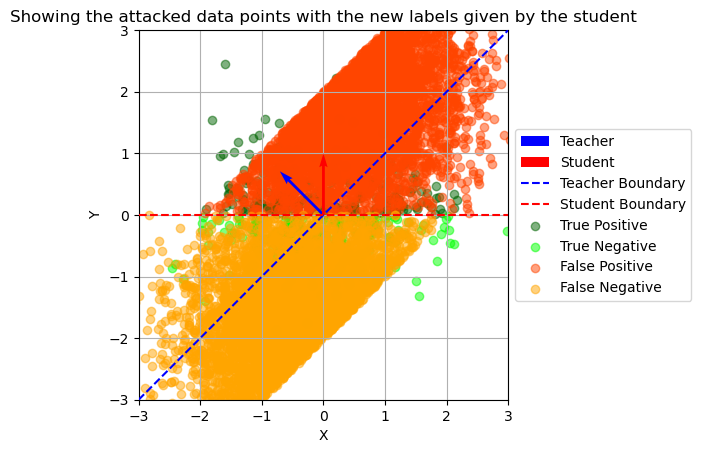

In [14]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the vectors as solid lines with arrows
ax.quiver(0, 0, theta[0], theta[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Teacher', linewidth=1.5, zorder=2)
ax.quiver(0, 0, w[0], w[1], angles='xy', scale_units='xy', scale=1, color='red', label='Student', linewidth=1.5, zorder=2)

lim = 3

# Plot the dashed lines for each vector
ax.plot([-lim, lim], [theta[0]*lim/theta[1],-theta[0]*lim/theta[1]], 'b--', label='Teacher Boundary', zorder=3)
ax.plot([-lim, lim], [w[0]*lim/w[1],-w[0]*lim/w[1]], 'r--', label='Student Boundary', zorder=3)

# Plot the data
ax.scatter(true_positive_attacked[:,0], true_positive_attacked[:,1], color='darkgreen', label='True Positive', zorder=1,alpha=0.5)
ax.scatter(true_negative_attacked[:,0], true_negative_attacked[:,1], color='lime', label='True Negative', zorder=1,alpha=0.5)
ax.scatter(false_positive_attacked[:,0], false_positive_attacked[:,1], color='orangered', label='False Positive', zorder=1,alpha=0.5)
ax.scatter(false_negative_attacked[:,0], false_negative_attacked[:,1], color='orange', label='False Negative', zorder=1,alpha=0.5)


# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
# put the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set axis limits
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

# make the grid spacing rectangular
ax.set_aspect('equal', adjustable='box')

plt.title("Showing the attacked data points with the new labels given by the student")

# Show the plot
plt.grid()
plt.show()


#### Notice how some points will transition from being false negatives to being true negatives w.r.t. the teacher boundary

# Let's attack the data-points and evaluate their labels against the teacher boundary

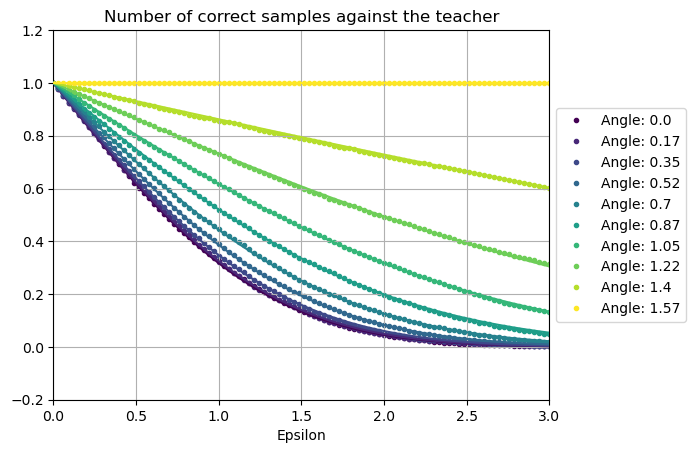

In [15]:
# Sample some data
data_set = data_model.generate_data(10000,0)
X = data_set.X


def angle_to_weights(angle):
    helper = np.random.uniform(0, 2*np.pi)
    theta = np.array([np.cos(helper), np.sin(helper)])
    helper += angle
    w = np.array([np.cos(helper), np.sin(helper)])
    return theta, w


def get_number_of_correct_samples_against_teacher(epsilon, w, theta):
    
    y_unattacked_techer = np.sign(X.dot(theta))
    # Let's try directly attacking the activation
    X_attacked = X - epsilon*y_unattacked_techer[:,np.newaxis]*w/np.linalg.norm(w)

    y_attacked_teacher = np.sign(X_attacked.dot(theta))
    

    # Count the number of attacked samples that are still correct w.r.t. the teacher
    number_of_correct_attacked_samples = np.mean(y_attacked_teacher == y_unattacked_techer)
    return number_of_correct_attacked_samples

def analytic_solution(epsilon, w, theta):
    m = w.dot(theta)
    q = np.linalg.norm(w)
    rho = theta.dot(theta)
    
    return erf(-epsilon*m/np.sqrt(2*q))+1
    


epsilons = np.linspace(0, 3 ,100)
angles = np.linspace(0,np.pi/2,10)
correct_samples_per_angle = np.zeros((len(angles), len(epsilons)))
analytic = np.zeros((len(angles), len(epsilons)))
for i, angle in enumerate(angles):
    theta, w = angle_to_weights(angle)
    correct_samples_per_angle[i,:] = np.array([ get_number_of_correct_samples_against_teacher(e, w, theta) for e in epsilons ])
    analytic[i,:] = np.array([ analytic_solution(e, w, theta) for e in epsilons ])


# Create a figure and axis
fig, ax = plt.subplots()

# get a set of 10 colors
colors = plt.cm.viridis(np.linspace(0,1,len(angles)))

# Plot the vectors as solid lines with arrows
for i, angle in enumerate(angles):
    ax.plot(epsilons, correct_samples_per_angle[i],".", color=colors[i],  label='Angle: '+str(round(angle,2)), zorder=1)
    ax.plot(epsilons, analytic[i], "-", color=colors[i], zorder=3)

# Add labels and legend
ax.set_xlabel('Epsilon')

# put the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set axis limits
ax.set_xlim(0, 3)
ax.set_ylim(-0.2, 1.2)

plt.title("Number of correct samples against the teacher")

# Show the plot
plt.grid()
plt.show()


